# Dataset INPI-BR (todas as versões)

Construindo os dados a partir da RPI 

`dense_dataset.csv` é gerado com cada linha do arquivo representando um único pedido/registro de patente e contendo todos os símbolos IPC presentes em sua classificação. Por isso, o nome denso, mais informação por registro/observação/exemplo/linha.

Existe uma versão esparsa `sparse_dataset.csv`, opcional, onde cada pedido de patente é repetido de acordo como o número de símbolos IPC presentes em sua classificação. Ou seja, apenas um símbolo IPC para cada linha do CSV. Esse dataset está montado assim para facilitar sua utilização em projetos de classificação IPC.

In [1]:
import os
import sys
sys.path.append('../')  # running from `project_root/notebooks`
import numpy as np
import pandas as pd
from machine_learning import ENV, plot_dist, text_length_hist, count_words, STOP_WORDS, plot_wordcloud, plot_bars, get_word_df
from operator import itemgetter

## despatchs.csv

Existiram várias versões do CSV de despachos (despatchs.csv) durante o desenvolvimento
- **despatchs_v1.csv**
    - utilizada para construir o dense_dataset_v1
    - 1260609 linhas sendo a primeira: `cd_despacho|no_pedido|ipc|title|abstract|rpi_date|rpi`
    - muitas linhas não contavam com o no_pedido, pois, patentes registradas tinham no_registro

- **despatchs_v2.csv**
    - criada para permitir recuperar os resumos vazios da base de dados do EPO
    - 1260609 linhas sendo a primeira: `cd_despacho|no_pedido|ipc|title|abstract|rpi_date|rpi`
    - no_pedido preenchido com dados do no_registro quando necessário

- **despatchs_v3.csv**
    - criada para permitir gerar a distribuição pela data de depósito
    - 1260609 linhas, sendo a primeira: `cd_despacho|no_pedido|ipc|title|abstract|rpi_date|rpi|deposit_date`
    - antes só era possível avaliar a distribuição no tempo através da data de classificação

### despatchs_v1 (`cd_despacho|no_pedido|ipc|title|abstract|rpi_date|rpi`)

- utilizada para construir o dense_dataset_v1
- 1260609 linhas sendo a primeira: `cd_despacho|no_pedido|ipc|title|abstract|rpi_date|rpi`
- muitas linhas não contavam com o no_pedido, pois, patentes registradas tinham no_registro

In [2]:
csv_file = os.path.join(ENV['OUTPUT_FOLDER'], 'despatchs_v1.csv')
df = pd.read_csv(csv_file, 
                 sep=ENV['DELIMITER'], 
                 parse_dates=['rpi_date'],
                 dtype={
                     'rpi': str,
                 })
df.shape
df.sample(5)
df.describe(include='all', datetime_is_numeric=True)

(1260608, 7)

,cd_despacho,no_pedido,ipc,title,abstract,rpi_date,rpi
145546,16.1,NaN,H01H 85/22,MONTAGEM DE FUSÍVEL,NaN,2001-02-20,1572
79146,3.1,PI9602266,H01M 10/48,"APARELHO DE PROLONGAMENTO DE BATERIA, COMBINAÇ...",Patente de Invenção de <B>'' APARELHO DE PROLO...,1998-10-27,1451
58904,3.1,PI9501672,F25B 39/04,Condensador para sistema de refrigeração.,"Patente de Invenção de ""CONDENSADOR PARA SISTE...",1997-09-16,1398
592657,1.3,PI0916159-7,B62D 53/08,MÉTODO E SISTEMA DE REGULAGEM DE POSIÇÃO LINEA...,NaN,2015-10-11,2340
1138872,6.21,BR112019012437-3,H04W 72/04,NaN,NaN,2020-09-24,2594


,cd_despacho,no_pedido,ipc,title,abstract,rpi_date,rpi
count,1260608,1106697,1260608,841047,355512,1259968,1260608
unique,66,902068,415611,721515,347607,NaN,1508
top,1.3,BR102017020904-0,A61F 13/15,ARTIGO ABSORVENTE,"A presente invenção refere-se, geralmente, a f...",NaN,2464
freq,384745,8,1929,308,13,NaN,35021
mean,NaN,NaN,NaN,NaN,NaN,2013-03-20 19:24:59.992380160,NaN
min,NaN,NaN,NaN,NaN,NaN,1992-01-09 00:00:00,NaN
25%,NaN,NaN,NaN,NaN,NaN,2008-04-03 00:00:00,NaN
50%,NaN,NaN,NaN,NaN,NaN,2016-04-19 00:00:00,NaN
75%,NaN,NaN,NaN,NaN,NaN,2019-02-19 00:00:00,NaN
max,NaN,NaN,NaN,NaN,NaN,2021-12-01 00:00:00,NaN


### despatchs_v2 (`cd_despacho|no_pedido|ipc|title|abstract|rpi_date|rpi`)

- criada para permitir recuperar os resumos vazios da base de dados do EPO
- 1260609 linhas sendo a primeira: `cd_despacho|no_pedido|ipc|title|abstract|rpi_date|rpi`
- no_pedido preenchido com dados do no_registro quando necessário

In [3]:
csv_file = os.path.join(ENV['OUTPUT_FOLDER'], 'despatchs_v2.csv')
df = pd.read_csv(csv_file, 
                 sep=ENV['DELIMITER'], 
                 parse_dates=['rpi_date'],
                 dtype={
                     'rpi': str,
                 })
df.shape
df.sample(5)
df.describe(include='all', datetime_is_numeric=True)

(1260608, 7)

,cd_despacho,no_pedido,ipc,title,abstract,rpi_date,rpi
681532,1.1,BR112016029032,"H01L 31/048,H01L 31/049",NaN,NaN,2016-12-20,2398
777032,1.3,BR112016017045-8,"C07D 487/04,A61K 45/06",DERIVADOS DE DIAZEPANO E USOS DOS MESMOS,NaN,2017-08-08,2431
52822,16.1,PI8906167,A63B 21/00,Aparelho para condicionamento físico.,NaN,1997-03-25,1373
474795,3.1,PI1102736-3,B27L 11/02,SISTEMA DE CABEÇOTE REGULAVÉL PARA MÁQUINA DE ...,SISTEMA DE CABEÇOTE REGULAVÉL PARA MÁQUINA DE ...,2013-07-16,2219
181156,1.3,PI0014464,"C07K 14/62,C12N 15/10,C12N 15/63,C12N 15/70",PEPTÍDEO C PARA PREPARAÇÃO APERFEIÇOADA DE INS...,"Patente de Invenção: ""PEPTÍDEO C PARA PREPARAÇ...",2002-11-06,1640


,cd_despacho,no_pedido,ipc,title,abstract,rpi_date,rpi
count,1260608,1260608,1260608,841047,355512,1259968,1260608
unique,66,935945,415611,721515,347607,NaN,1508
top,1.3,PI0004575-6,A61F 13/15,ARTIGO ABSORVENTE,"A presente invenção refere-se, geralmente, a f...",NaN,2464
freq,384745,10,1929,308,13,NaN,35021
mean,NaN,NaN,NaN,NaN,NaN,2013-03-20 19:24:59.992380160,NaN
min,NaN,NaN,NaN,NaN,NaN,1992-01-09 00:00:00,NaN
25%,NaN,NaN,NaN,NaN,NaN,2008-04-03 00:00:00,NaN
50%,NaN,NaN,NaN,NaN,NaN,2016-04-19 00:00:00,NaN
75%,NaN,NaN,NaN,NaN,NaN,2019-02-19 00:00:00,NaN
max,NaN,NaN,NaN,NaN,NaN,2021-12-01 00:00:00,NaN


### despatchs_v3 (`cd_despacho|no_pedido|ipc|title|abstract|rpi_date|rpi|deposit_date`)

- criada para permitir gerar a distribuição pela data de depósito
- 1260609 linhas, sendo a primeira: `cd_despacho|no_pedido|ipc|title|abstract|rpi_date|rpi|deposit_date`
- antes só era possível avaliar a distribuição no tempo através da data de classificação

In [4]:
csv_file = os.path.join(ENV['OUTPUT_FOLDER'], 'despatchs_v3.csv')
df = pd.read_csv(csv_file, 
                 sep=ENV['DELIMITER'], 
                 parse_dates=['rpi_date', 'deposit_date'],
                 dtype={
                     'rpi': str,
                 })
df.shape
df.sample(5)
df.describe(include='all', datetime_is_numeric=True)

(1260608, 8)

,cd_despacho,no_pedido,ipc,title,abstract,rpi_date,rpi,deposit_date
522044,1.1,BR112014013798,"C07C 51/42,C07C 55/02,C07C 57/02,C12P 7/44,C12...",NaN,NaN,2014-08-19,2276,NaN
712736,1.1,BR112017008897,"C07C 45/71,C10L 1/02,B01J 31/02",NaN,NaN,2017-05-30,2421,NaN
277891,1.3,PI0411154,"B29C 44/02,B29C 51/02,B29C 67/20",MÉTODO DE PRODUÇÃO DE ARTIGOS TERMOFORMADOS A ...,"""MÉTODO DE PRODUÇÃO DE ARTIGOS TERMOFORMADOS A...",2006-11-07,1853,14/05/2004
722125,1.1,BR112017012030,B60R 21/045,NaN,NaN,2017-06-20,2424,NaN
275008,1.3,PI0411803,"C07K 16/28,C07K 16/30,A61K 39/395,C12N 5/16,C1...",ANTICORPOS DIRIGIDOS AOS MUTANTES DE DELEÇÃO D...,"""ANTICORPOS DIRIGIDOS AOS MUTANTES DE DELEÇÃO ...",2006-05-23,1846,25/06/2004


,cd_despacho,no_pedido,ipc,title,abstract,rpi_date,rpi,deposit_date
count,1260608,1260608,1260608,841047,355512,1259968,1260608,1022666
unique,66,935945,415611,721515,347607,NaN,1508,19266
top,1.3,PI0004575-6,A61F 13/15,ARTIGO ABSORVENTE,"A presente invenção refere-se, geralmente, a f...",NaN,2464,14/03/2014
freq,384745,10,1929,308,13,NaN,35021,1331
mean,NaN,NaN,NaN,NaN,NaN,2013-03-20 19:24:59.992380160,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,1992-01-09 00:00:00,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,2008-04-03 00:00:00,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,2016-04-19 00:00:00,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,2019-02-19 00:00:00,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,2021-12-01 00:00:00,NaN,NaN


## dense_dataset.csv

- **dense_dataset_v1.csv**
    - (346182, 6)
    - `classif_date|title|abstract|ipc|area|rpi_registro`
    - versão original, foi utilizada no ciclo 2 dos **experimentos**
    - produz 342.291 exemplos depois de limpo

- **dense_dataset_v2.csv**
    - (680359, 7)
    - `no_pedido|classif_date|title|abstract|ipc|area|rpi_registro`
    - permite recuperar o **resumo na EPO**, via OPS
    - produz 342.704 exemplos depois de limpo

- **dense_dataset_v3.csv**
    - (346165, 8)
    - `no_pedido|classif_date|title|abstract|ipc|area|last_rpi|deposit_date`
    - apenas permitir gerar a **distribuição pela data de deposito**
    - gerado a partir de despatchs_v3.csv, mas incluindo apenas as linhas cujo título e o resumo não estavam vazios
    - produz 342.423 exemplos depois de limpo

- **dense_dataset_v4.csv**
    - (672935, 8)
    - `no_pedido|classif_date|title|abstract|ipc|area|last_rpi|deposit_date`
    - permitir gerar a distribuição pela **data de depósito** & recuperar o **resumo na EPO**, via OPS
    - gerado a partir de despatchs_v3.csv, incluindo todas as linhas contendo a área de exame
    
- **dense_dataset_v5 => dense_dataset_evaluation.csv**
    - (385673, 8)
    - `no_pedido|classif_date|title|abstract|ipc|area|last_rpi|deposit_date`
    - gerado a partir do dense_dataset_v4 incluindo resumos obtidos no EPO
    - produz 385.673 exemplos depois de limpo

### dense_dataset_v1

- (346182, 6)
- `classif_date|title|abstract|ipc|area|rpi_registro`
- **versão original**, foi utilizada no ciclo 2 dos experimentos
- produz 342.291 exemplos depois de limpo

In [7]:
id_label = 'INPI-BR_v1'
csv_file = os.path.join(ENV['OUTPUT_FOLDER'], 'dense_dataset_v1.csv')
df_v1 = pd.read_csv(csv_file, 
                 sep=ENV['DELIMITER'], 
                 parse_dates=['classif_date'],
                 dtype={
                     'area': str,
                     'rpi_registro': int,
                 })
print(f'Formato dos dados: {df_v1.shape}')
df_v1.sample(5)

Formato dos dados: (346182, 6)


,classif_date,title,abstract,ipc,area,rpi_registro
314812,2012-10-02,DISPOSIÇÃO TÉCNICA INTRODUZIDA EM CALCANHEIRA ...,A presente patente de modelo de utilidade diz ...,['A43B 21/32'],DINEC,2178
294348,2011-05-03,DISPOSIÇÃO CONSTRUTIVA APLICADA EM COLHEDEIRA,DISPOSIÇÃO CONSTRUTIVA APLICADA EM COLHEDEIRA ...,['A01D 46/20'],DIPAE,2104
83327,1999-12-28,Método para reduzir a formação de fase beta em...,MÉTODO PARA REDUZIR A FORMAÇÃO DE FASE BETA EM...,"['C22C 1/02', 'C22F 1/043']",DIMAT,1512
309686,2018-03-06,MÉTODO PARA DETECTAR A QUANTITADE DE GRÃOS DEN...,MÉTODO PARA DETECTAR A QUANTIDADE DE GRÃOS DEN...,"['G06F 7/00', 'A47J 31/06', 'A47J 31/40']",DICEL,2142
239883,2007-07-24,GRADE DE PROTEÇÃO PARA CRIANÇAS E PEQUENOS ANI...,GRADE DE PROTEÇÃO PARA CRIANÇAS E PEQUENOS ANI...,['E06B 9/00'],DICIV,1907


#### Análise e Remoção das linhas com valores nulos

In [8]:
print(f'Quantidade de exemplos com valores nulos:\n{df_v1.isna().sum()}')
print('Limpando os nulos...')
df_v1.dropna(subset=['classif_date', 'title', 'abstract', 'area'], inplace=True)
print(f'Formato dos dados: {df_v1.shape}')

Quantidade de exemplos com valores nulos:
classif_date       0
title              0
abstract           0
ipc                0
area            3842
rpi_registro       0
dtype: int64
Limpando os nulos...
Formato dos dados: (342340, 6)


#### Análise e Remoção das linhas duplicadas

In [9]:
df_duplicated_v1 = df_v1[df_v1.duplicated()]
print(f'Quantidade de exemplos duplicados: {df_duplicated_v1.shape[0]}')
df_duplicated_v1.head(10)
print('Limpando os duplicados...')
df_v1.drop_duplicates(inplace=True)
print(f'Formato dos dados: {df_v1.shape}')

Quantidade de exemplos duplicados: 49


,classif_date,title,abstract,ipc,area,rpi_registro
672,1992-09-08,Lâmpada fluorescente compactada provida de sta...,Patente de invenção da lâmpada fluorescente co...,['H05B 41/14'],DIFEL,1136
12363,1993-10-26,Porca especialmente porca de roda,A invenção se refere a uma porca fabricada pel...,['F16B 37/00'],DITEM,1195
86204,2000-02-01,MÁQUINA E SISTEMA BANCÁRIOS AUTOMATIZADOS,MÁQUINA E SISTEMA BANCÁRIOS AUTOMATIZADOS Trat...,['G07F 19/00'],DIFEL,1517
94804,2000-05-30,PROCESSO DE FABRICAÇÃO DE BLOCOS DE CONCRETO,PROCESSO DE FABRICAÇÃO DE BLOCOS DE CONCRETO d...,['B28D 1/00'],DICIV,1534
101659,2000-09-12,MÁQUINA E SISTEMA BANCÁRIOS AUTOMATIZADOS,MÁQUINA E SISTEMA BANCÁRIOS AUTOMATIZADOS Trat...,['G07F 19/00'],DIFEL,1549
104880,2000-10-10,ENGATE RÁPIDO DUPLO PARA SUGADORES ODONTOLÓGICOS,ENGATE RÁPIDO DUPLO PARA SUGADORES DESCARTÁVEI...,['A61C 17/06'],DINEC,1553
121787,2001-07-24,TRANSPORTADOR DE RECIPIENTE COM PAINEL DE ETIQ...,TRANSPORTADOR DE RECIPIENTE COM PAINEL DE ETIQ...,['B65B 27/04'],DITEM,1594
133309,2002-01-22,ENZIMA DE SUBTILASE SUBTILASE SEQÜÊNCIA ISOLAD...,ENZIMA DE SUBTILASE SUBTILASE SEQUÊNCIA ISOLAD...,['C12N 9/54'],DIALP,1620
135867,2002-02-26,AMORTECEDOR DE CHOQUE VARIÁVEL CONTÍNUO ATUADO...,Patente de Invenção AMORTECEDOR DE CHOQUE VARI...,['F16F 9/48'],DITEM,1625
150138,2002-11-26,VERNIZ PARA ACABAMENTO SUPERFICIAL E MECÂNICO,VERNIZ PARA ACABAMENTO SUPERFICIAL E MECÂNICO ...,['C09D 5/00'],DITEX,1664


Limpando os duplicados...
Formato dos dados: (342291, 6)


#### Estatísticas

In [10]:
df_v1.describe(include='all', datetime_is_numeric=True)

,classif_date,title,abstract,ipc,area,rpi_registro
count,342291,342291,342291,342291,342291,342291.000000
unique,NaN,327472,341931,177337,19,NaN
top,NaN,PNEUMÁTICO,MÉTODOS DE PRODUZIR UM PRODUTO DE PETRÓLEO BRU...,['A61F 13/15'],DINEC,NaN
freq,NaN,106,7,985,42110,NaN
mean,2005-12-08 03:42:51.022901888,NaN,NaN,NaN,NaN,1740.938418
min,1900-01-01 00:00:00,NaN,NaN,NaN,NaN,1132.000000
25%,2000-08-08 00:00:00,NaN,NaN,NaN,NaN,1521.000000
50%,2005-04-26 00:00:00,NaN,NaN,NaN,NaN,1742.000000
75%,2011-03-09 00:00:00,NaN,NaN,NaN,NaN,1966.000000
max,2021-10-26 00:00:00,NaN,NaN,NaN,NaN,2335.000000


#### Distribuição dos exemplos pela data de classificação

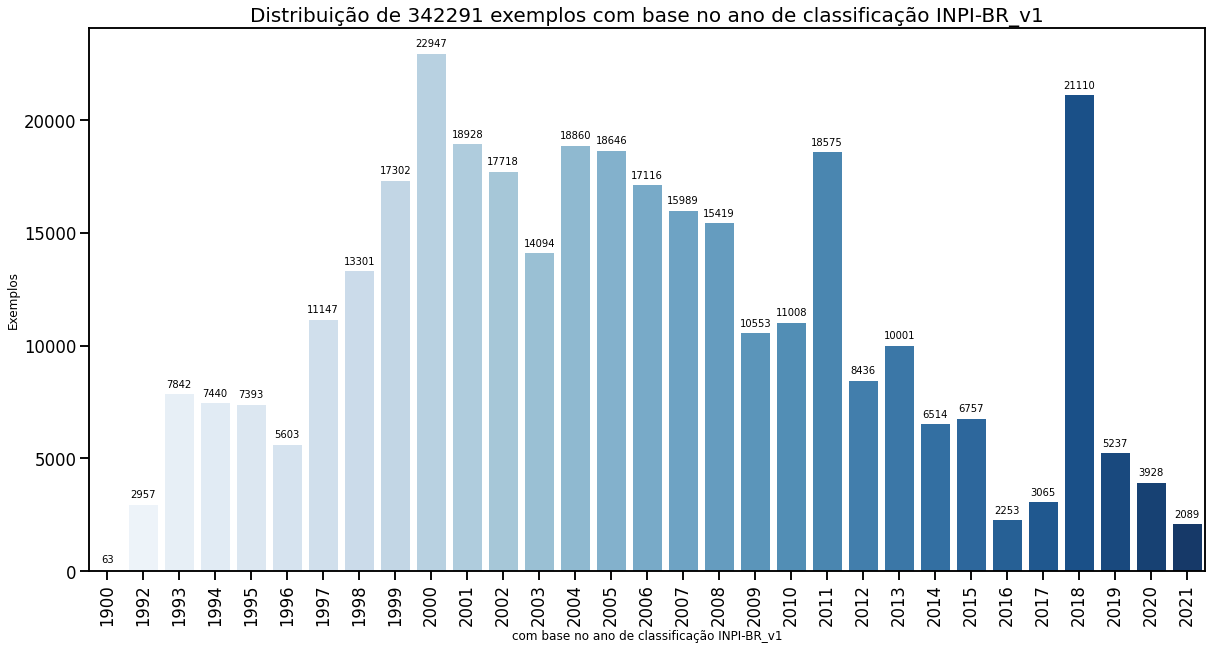

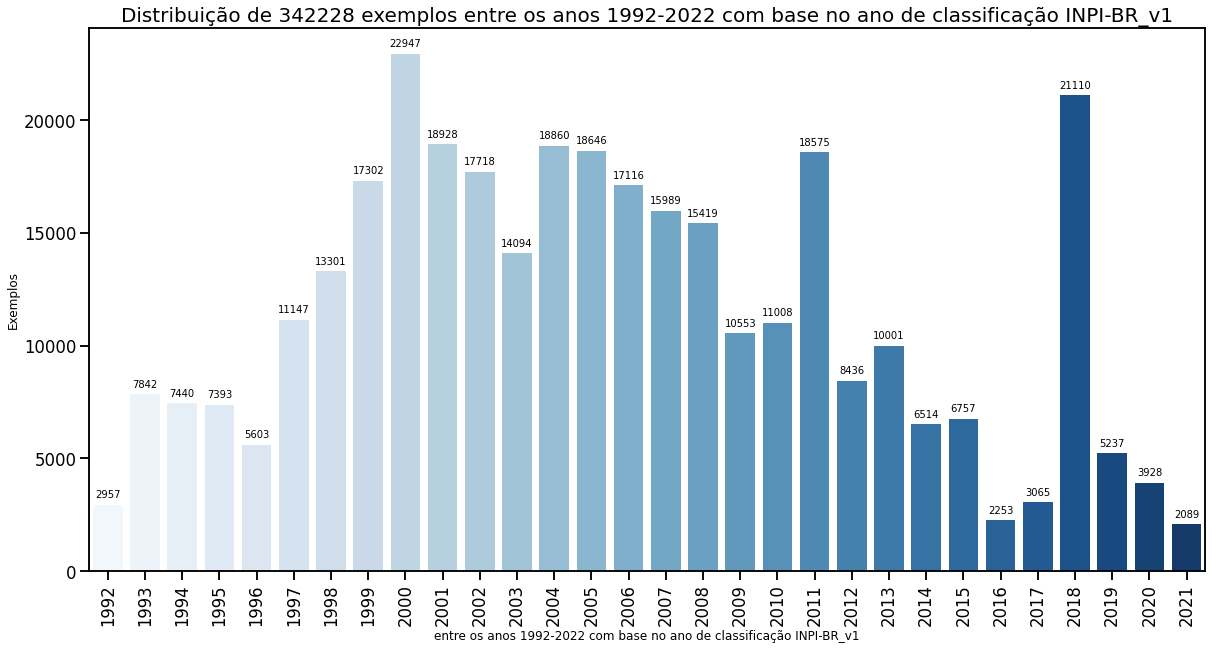

In [11]:
df_plot = df_v1.dropna(subset=['classif_date'])

# complete dataset
plot_dist(df_plot['classif_date'].dt.year, label=f'com base no ano de classificação {id_label}', palette='Blues');

# only between 1992 and 2022, both inclusive
df_year = df_plot['classif_date'].dt.year
df_year = df_year[df_year.between(1992, 2022)]
plot_dist(df_year, label=f'entre os anos 1992-2022 com base no ano de classificação {id_label}', palette='Blues');

#### Distribuição dos exemplos pela área de exame

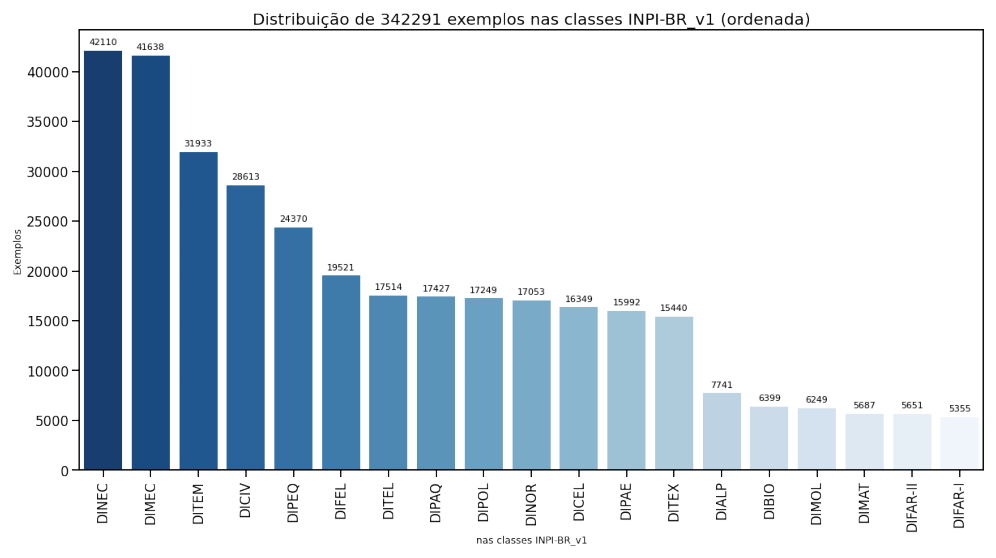

In [13]:
plot_dist(df_v1['area'], label=f'nas classes {id_label}', sort=True, data_points_fontsize=11, palette='Blues_r');

#### Distribuição dos exemplos pela data de depósito

In [15]:
df_plot = df_v1.dropna(subset=['deposit_date'])

# complete dataset
plot_dist(df_plot['deposit_date'].dt.year, label=f'com base no ano de depósito {id_label}', palette='Blues');

# only between 1992 and 2022, both inclusive
df_year = df_plot['deposit_date'].dt.year
df_year = df_year[df_year.between(1992, 2022)]
plot_dist(df_year, label=f'entre os anos 1992-2022 com base no ano de depósito {id_label}', palette='Blues');

KeyError: ['deposit_date']

### dense_dataset_v2

- (680359, 7)
- `no_pedido|classif_date|title|abstract|ipc|area|rpi_registro`
- permite recuperar o **resumo na EPO**, via OPS
- produz 342.704 exemplos depois de limpo

In [9]:
csv_file = os.path.join(ENV['OUTPUT_FOLDER'], 'dense_dataset_v2.csv')
df_v2 = pd.read_csv(csv_file, 
                 sep=ENV['DELIMITER'], 
                 parse_dates=['classif_date'],
                 dtype={
                     'area': str,
                     'rpi_registro': int,
                 })
print(f'Formato dos dados: {df_v2.shape}')
df_v2.sample(5)

Formato dos dados: (680359, 7)


,no_pedido,classif_date,title,abstract,ipc,area,rpi_registro
8989,PI9200218,2001-02-06,APARELHO E PROCESSO PARA O PROCESSAMENTO DE FI...,A invenção proporciona um aparelho para o proc...,['D01C 3/00'],DITEX,1167
526931,BR112016020801,2017-08-15,?PLACA MÃE TÊXTIL COM MODULAR E PROJETO INTERC...,NaN,['A61M 1/36'],DICEL,2391
52841,PI9506302,1997-08-05,Sistema de comunicação para acoplar uma plural...,ARQUITETURA DO SISTEMA DE COMUNICAÇÃO AVANçADA...,"['H04Q 11/04', 'H04L 12/40']",DITEL,1392
129581,PI0005455,2001-01-30,ANTENA DE BANDA MÚLTIPLA,Patente de Invenção ANTENA DE BANDA MÚLTIPLA A...,['H01Q 21/30'],DITEL,1569
138857,PI9905531,2018-03-27,VÁLVULA DE RETENÇÃO COM HASTE,VÁLVULA DE RETENÇÃO COM HASTE Patente de Inven...,"['B67D 7/36', 'F16K 15/18']",DITEM,1594


#### Análise e Remoção das linhas com valores nulos

In [10]:
print(f'Quantidade de exemplos com valores nulos:\n{df_v2.isna().sum()}')
print('Limpando os nulos...')
df_v2.dropna(subset=['classif_date', 'title', 'abstract', 'area'], inplace=True)
print(f'Formato dos dados: {df_v2.shape}')

Quantidade de exemplos com valores nulos:
no_pedido            0
classif_date         0
title            18954
abstract        334190
ipc                  0
area              7424
rpi_registro         0
dtype: int64
Limpando os nulos...
Formato dos dados: (342704, 7)


#### Análise e Remoção das linhas duplicadas

In [11]:
df_duplicated_v2 = df_v2[df_v2.duplicated()]
print(f'Quantidade de exemplos duplicados: {df_duplicated_v2.shape[0]}')
df_duplicated_v2.head(10)
print('Limpando os duplicados...')
df_v2.drop_duplicates(inplace=True)
print(f'Formato dos dados: {df_v2.shape}')

Quantidade de exemplos duplicados: 0


,no_pedido,classif_date,title,abstract,ipc,area,rpi_registro


Limpando os duplicados...
Formato dos dados: (342704, 7)


#### Estatísticas

In [12]:
df_v2.shape
df_v2.sample(5)
df_v2.describe(include='all', datetime_is_numeric=True)

(342704, 7)

,no_pedido,classif_date,title,abstract,ipc,area,rpi_registro
153198,PI0003162,2002-02-26,LÂMINA DE SERRA CIRCULAR,LÂMINA DE SERRA CIRCULAR Se divulga uma lâmina...,['B27B 5/29'],DIMEC,1625
301271,MU8803147,2010-07-06,CÁLICE DESCARTÁVEL,A presente Patente de Modelo de Utilidade refe...,['A47G 33/00'],DINEC,2061
128174,PI9910055,2001-01-09,ELEMENTO DE SEGURANÇA PARA IMPEDIR FALSIFICAÇÃ...,Patente de Invenção ELEMENTO DE SEGURANÇA PARA...,['G06K 19/08'],DICEL,1566
308265,PI0613624,2011-01-18,USO DE UM COMPOSTO OU UM SAL OU SOLVATO FARMAC...,USO DE UM COMPOSTO OU UM SAL OU SOL VATO FARMA...,"['A61K 31/426', 'A61K 31/421', 'A61P 3/10', 'A...",DIFAR-II,2089
433405,BR202012002997,2014-04-22,DISPOSIÇÃO INTRODUZIDA EM EQUIPAMENTO PARA TIR...,DISPOSIÇÃO INTRODUZIDA EM EQUIPAMENTO PARA TIR...,['E04H 12/00'],DICIV,2259


,no_pedido,classif_date,title,abstract,ipc,area,rpi_registro
count,342704,342704,342704,342704,342704,342704,342704.000000
unique,342704,NaN,328059,342291,177592,19,NaN
top,PI9007700,NaN,ARTIGO ABSORVENTE,MÉTODOS DE PRODUZIR UM PRODUTO DE PETRÓLEO BRU...,['A61F 13/15'],DINEC,NaN
freq,1,NaN,124,9,987,42135,NaN
mean,NaN,2007-05-28 05:48:15.093141248,NaN,NaN,NaN,NaN,1740.453613
min,NaN,1900-01-01 00:00:00,NaN,NaN,NaN,NaN,1132.000000
25%,NaN,2001-07-31 00:00:00,NaN,NaN,NaN,NaN,1520.000000
50%,NaN,2006-09-19 00:00:00,NaN,NaN,NaN,NaN,1742.000000
75%,NaN,2012-12-11 00:00:00,NaN,NaN,NaN,NaN,1965.000000
max,NaN,2021-10-26 00:00:00,NaN,NaN,NaN,NaN,2335.000000


### dense_dataset_v3

- (346165, 8)
- `no_pedido|classif_date|title|abstract|ipc|area|last_rpi|deposit_date`
- apenas permitir gerar a **distribuição pela data de deposito**
- gerado a partir do despatchs_v3, mas incluindo apenas as linhas cujo título e o resumo não estavam vazios
- produz 342.423 exemplos depois de limpo

In [13]:
csv_file = os.path.join(ENV['OUTPUT_FOLDER'], 'dense_dataset_v3.csv')
df_v3 = pd.read_csv(csv_file, 
                 sep=ENV['DELIMITER'], 
                 parse_dates=['classif_date', 'deposit_date'],
#                  parse_dates=['classif_date'],
                 dtype={
                     'area': str,
                     'last_rpi': int,
                 })
print(f'Formato dos dados: {df_v3.shape}')
df_v3.sample(5)

Formato dos dados: (346165, 8)


,no_pedido,classif_date,title,abstract,ipc,area,last_rpi,deposit_date
310143,PI1002165,2012-02-07,MÁQUINA AUTOMÁTICA DE INTERNET E TELEFONIA VOI...,MÁQUINA AUTOMÁTICA DE INTERNET E TELEFONIA VOI...,"['G07F 17/30', 'H04L 29/06']",DIFEL,2144,2010-04-23
245196,PI0510474,2007-11-06,MENSAGENS DE CONTROLE DE COMUNICAÇÃO PARA SERV...,MENSAGENS DE CONTROLE DE COMUNICAÇÃO PARA SERV...,['H04B 7/26'],DITEL,1922,2005-08-12
11566,PI9301206,1993-09-21,PROCESSO PARA SELAR UMA GARRAFA E SELADOR PARA...,Processo para selar uma garrafa por deformação...,['B67B 3/02'],DITEM,1190,1993-03-17
33155,PI9503589,1996-04-09,PROCESSO E DISPOSITIVO PARA O ARREDONDAMENTO D...,Patente de invenção PROCESSO DISPOSITIVO PARA ...,['B21D 51/26'],DIMEC,1323,1995-08-09
8755,MU7202093,1993-05-25,Disposição em moldador de alimentos recheados,DISPOSIÇÃO EM MOLDADOR DE ALIMENTOS RECHEADOS ...,"['A21C 11/00', 'A47J 43/20']",DIPAE,1173,1992-12-02


#### Análise e Remoção das linhas com valores nulos

In [14]:
print(f'Quantidade de exemplos com valores nulos:\n{df_v3.isna().sum()}')
print('Limpando os nulos...')
df_v3.dropna(subset=['classif_date', 'title', 'abstract', 'area'], inplace=True)
print(f'Formato dos dados: {df_v3.shape}')

Quantidade de exemplos com valores nulos:
no_pedido          0
classif_date     281
title              0
abstract           0
ipc                0
area            3461
last_rpi           0
deposit_date    2099
dtype: int64
Limpando os nulos...
Formato dos dados: (342423, 8)


#### Análise e Remoção das linhas duplicadas

In [15]:
df_duplicated_v3 = df_v3[df_v3.duplicated()]
print(f'Quantidade de exemplos duplicados: {df_duplicated_v3.shape[0]}')
df_duplicated_v3.head(10)
print('Limpando os duplicados...')
df_v3.drop_duplicates(inplace=True)
print(f'Formato dos dados: {df_v3.shape}')

Quantidade de exemplos duplicados: 0


,no_pedido,classif_date,title,abstract,ipc,area,last_rpi,deposit_date


Limpando os duplicados...
Formato dos dados: (342423, 8)


#### Estatísticas

In [16]:
df_v3.shape
df_v3.sample(5)
df_v3.describe(include='all', datetime_is_numeric=True)

(342423, 8)

,no_pedido,classif_date,title,abstract,ipc,area,last_rpi,deposit_date
246945,PI0511177,2007-12-04,PROCESSO DE ADSORÇÃO POR OSCILAÇÃO DE PRESSÃO,PROCESSO DE ADSORÇÃO POR OSCILAÇÃO DE PRESSÃO ...,['B01D 53/047'],DINOR,1926,2005-05-18
39003,MU7500816,1997-05-13,Kit didático e recreativo para estimular a cap...,Trata se de um Kit constituído de um conjunto ...,"['A63F 9/18', 'G09B 3/12']",DINEC,1380,1995-04-27
288846,PI0613533,2011-01-18,COMPOSIÇÕES DE CICLOSPORINA,COMPOSIÇÕES DE CICLOSPORINA A presente invençã...,"['A61K 9/107', 'A61K 38/13']",DIFAR-I,2089,2006-07-12
232171,PI0309027,2007-01-30,SISTEMA E MÉTODO PARA CONTROLE REMOTO E MÉTODO...,SISTEMA E MÉTODO PARA CONTROLE REMOTO PARA GRA...,"['G11B 19/02', 'G11B 19/16', 'G11B 15/02']",DICEL,1882,2003-04-02
108652,PI9903814,2018-03-27,COMPOSIÇÃO FORMADORA DE FILME COMPOSIÇÃO COSMÉ...,COMPOSIÇÃO FORMADORA DE FILME COMPOSIÇÃO COSMÉ...,"['A61K 8/898', 'A61K 8/85', 'A61K 8/891', 'A61...",DIBIO,1559,1999-08-27


,no_pedido,classif_date,title,abstract,ipc,area,last_rpi,deposit_date
count,342423,342423,342423,342423,342423,342423,342423.000000,340347
unique,342423,NaN,327813,342013,177459,19,NaN,NaN
top,PI9007700,NaN,ARTIGO ABSORVENTE,MÉTODOS DE PRODUZIR UM PRODUTO DE PETRÓLEO BRU...,['A61F 13/15'],DINEC,NaN,NaN
freq,1,NaN,124,9,987,42118,NaN,NaN
mean,NaN,2005-09-22 10:22:19.753462784,NaN,NaN,NaN,NaN,1740.067852,2002-04-07 19:51:06.770090368
min,NaN,1992-08-11 00:00:00,NaN,NaN,NaN,NaN,1132.000000,1900-12-31 00:00:00
25%,NaN,2000-08-08 00:00:00,NaN,NaN,NaN,NaN,1520.000000,1998-02-24 00:00:00
50%,NaN,2005-03-29 00:00:00,NaN,NaN,NaN,NaN,1742.000000,2002-05-17 00:00:00
75%,NaN,2010-12-28 00:00:00,NaN,NaN,NaN,NaN,1965.000000,2006-04-13 00:00:00
max,NaN,2021-10-26 00:00:00,NaN,NaN,NaN,NaN,2335.000000,2015-05-11 00:00:00


### dense_dataset_v5

- (385673, 8)
- `no_pedido|classif_date|title|abstract|ipc|area|last_rpi|deposit_date`
- permitir gerar a distribuição pela **data de depósito** & recuperar o **resumo na EPO**, via OPS
- gerado a partir de despatchs_v3.csv, incluindo todas as linhas contendo a área de exame
- vários resumos recuperados do EPO
- produz 385.673 exemplos depois de limpo

In [17]:
id_label = 'INPI-BR_v5'
csv_file = os.path.join(ENV['OUTPUT_FOLDER'], 'dense_dataset_evaluation.csv')
df_v5 = pd.read_csv(csv_file, 
                 sep=ENV['DELIMITER'], 
                 parse_dates=['classif_date', 'deposit_date'],
                 dtype={
                     'area': str,
                     'last_rpi': int,
                 })
print(f'Formato dos dados: {df_v5.shape}')
df_v5.sample(5)

Formato dos dados: (385673, 8)


,no_pedido,classif_date,title,abstract,ipc,area,last_rpi,deposit_date
27285,PI9500750,1995-10-17,Composto de metal carbono cerâmico ligado por ...,Desenvolveu se um novo composto de metal carbo...,['C04B 35/00'],DINOR,1298,1995-02-23
225494,PI0414486,2006-11-14,DERIVADO DE QUINAZOLINA COMPOSIÇÃO FARMACÊUTIC...,DERIVADO DE QUINAZOLINA COMPOSIÇÃO FARMACÊUTIC...,"['C07D 401/14', 'C07D 401/12', 'C07D 413/12', ...",DIPAQ,1871,2004-09-14
259029,PI0517629,2008-10-14,FORMAS DE DOSAGEM DOTADAS DE UMA SUPERFÍCIE CO...,FORMAS DE DOSAGEM DOTADAS DE UMA SUPERFÍCIE CO...,"['A61K 9/20', 'A61K 9/28', 'A61J 3/00', 'B29C ...",DIFAR-I,1971,2005-10-26
145980,PI0016535,2002-09-24,DISPOSITIVO DE ILUMINAÇÃO PARA INSTALAÇÃO EM U...,DISPOSITIVO DE ILUMINAÇÃO PARA INSTALAÇÃO EM U...,['B64F 1/18'],DIMEC,1655,2000-12-20
270672,MU8800179,2009-09-29,DISPOSIÇÃO INTRODUZIDA EM CAMA,DISPOSIÇÃO INTRODUZIDA EM CAMA Trata se de uma...,['A61G 7/015'],DINEC,2021,2008-02-07


#### Análise e Remoção das linhas com valores nulos

In [18]:
print(f'Quantidade de exemplos com valores nulos:\n{df_v5.isna().sum()}')
print('Limpando os nulos...')
df_v5.dropna(subset=['abstract', 'area'], inplace=True)
print(f'Formato dos dados: {df_v5.shape}')

Quantidade de exemplos com valores nulos:
no_pedido           0
classif_date      281
title               0
abstract            0
ipc                 0
area                0
last_rpi            0
deposit_date    43493
dtype: int64
Limpando os nulos...
Formato dos dados: (385673, 8)


#### Análise e Remoção das linhas duplicadas

In [19]:
df_duplicated_v5 = df_v5[df_v5.duplicated()]
print(f'Quantidade de exemplos duplicados: {df_duplicated_v5.shape[0]}')
df_duplicated_v5.head(10)
print('Limpando os duplicados...')
df_v5.drop_duplicates(inplace=True)
print(f'Formato dos dados: {df_v5.shape}')

Quantidade de exemplos duplicados: 0


,no_pedido,classif_date,title,abstract,ipc,area,last_rpi,deposit_date


Limpando os duplicados...
Formato dos dados: (385673, 8)


#### Estatísticas

In [20]:
df_v5.describe(include='all', datetime_is_numeric=True)

,no_pedido,classif_date,title,abstract,ipc,area,last_rpi,deposit_date
count,385673,385392,385673,385673,385673,385673,385673.000000,342180
unique,385673,NaN,368869,385022,207655,19,NaN,NaN
top,PI9007700,NaN,ARTIGO ABSORVENTE,abstract not avaible,['A61F 13/15'],DIMEC,NaN,NaN
freq,1,NaN,160,83,1009,45587,NaN,NaN
mean,NaN,2007-01-08 02:02:50.830738432,NaN,NaN,NaN,NaN,1814.782808,2002-04-12 00:55:36.517622400
min,NaN,1992-08-11 00:00:00,NaN,NaN,NaN,NaN,1132.000000,1900-12-31 00:00:00
25%,NaN,2001-01-02 00:00:00,NaN,NaN,NaN,NaN,1543.000000,1998-02-16 00:00:00
50%,NaN,2006-05-09 00:00:00,NaN,NaN,NaN,NaN,1788.000000,2002-05-17 00:00:00
75%,NaN,2013-02-26 00:00:00,NaN,NaN,NaN,NaN,2100.000000,2006-04-20 00:00:00
max,NaN,2021-10-26 00:00:00,NaN,NaN,NaN,NaN,2645.000000,2020-01-30 00:00:00


#### Distribuição dos exemplos pela data de classificação

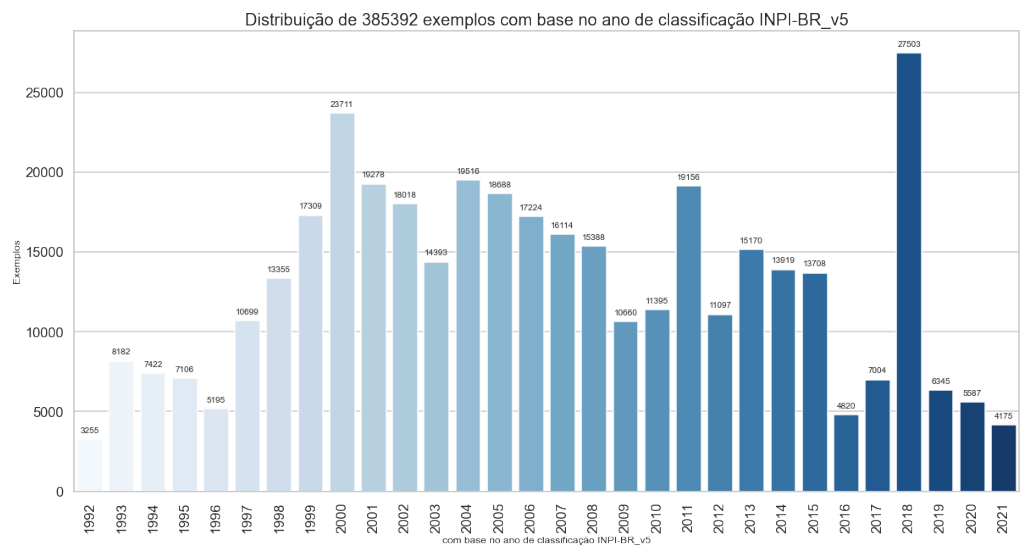

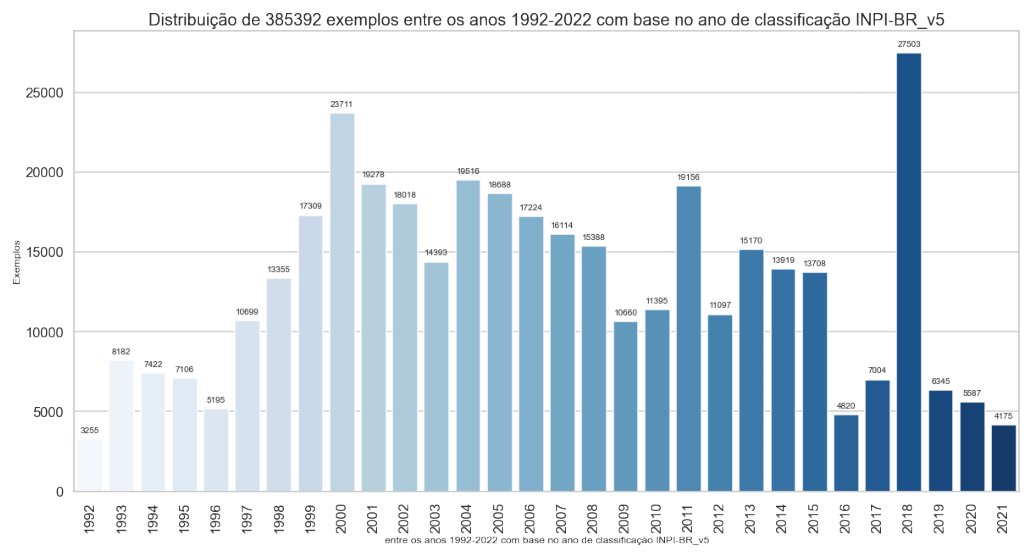

In [21]:
df_plot = df_v5.dropna(subset=['classif_date'])

# complete dataset
plot_dist(df_plot['classif_date'].dt.year, label=f'com base no ano de classificação {id_label}', palette='Blues');

# only between 1992 and 2022, both inclusive
df_year = df_plot['classif_date'].dt.year
df_year = df_year[df_year.between(1992, 2022)]
plot_dist(df_year, label=f'entre os anos 1992-2022 com base no ano de classificação {id_label}', palette='Blues');

#### Distribuição dos exemplos pela área de exame

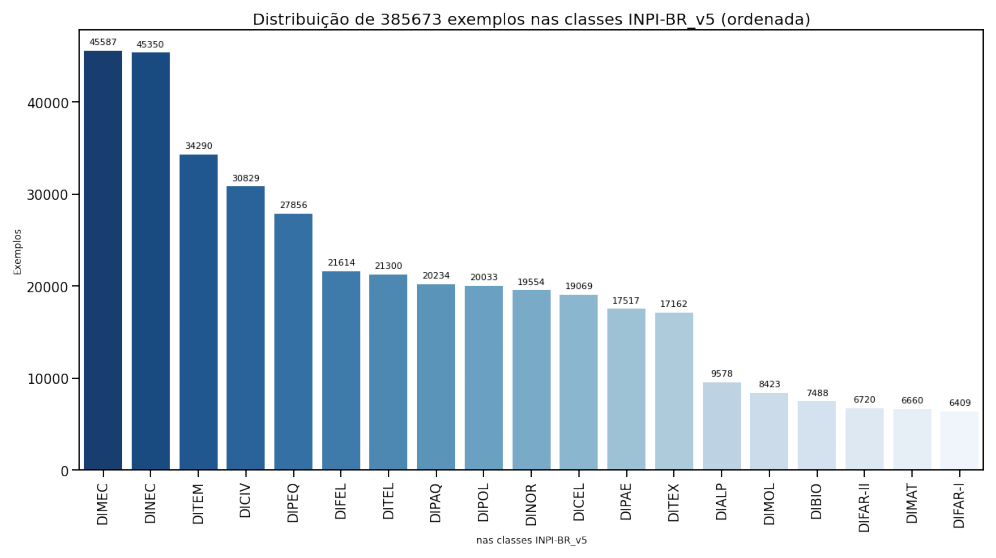

In [22]:
plot_dist(df_v5['area'], label=f'nas classes {id_label}', sort=True, data_points_fontsize=11, palette='Blues_r');


#### Distribuição dos exemplos pela data de depósito

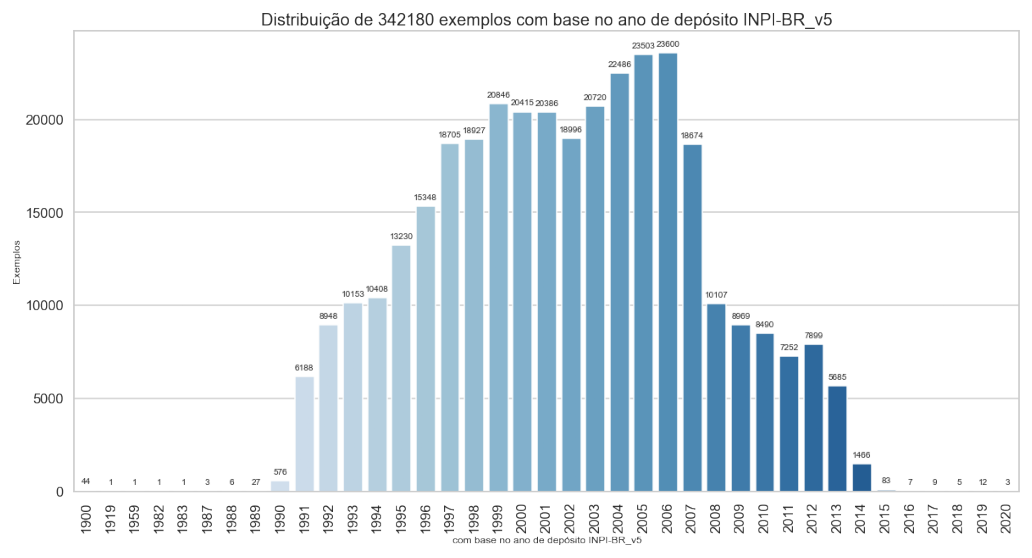

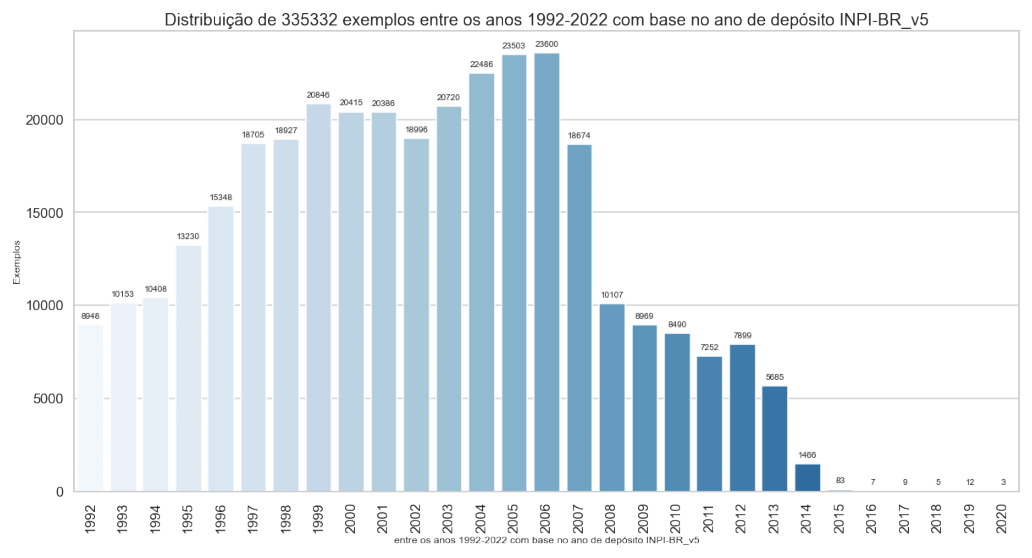

In [24]:
df_plot = df_v5.dropna(subset=['deposit_date'])

# complete dataset
plot_dist(df_plot['deposit_date'].dt.year, label=f'com base no ano de depósito {id_label}', palette='Blues');

# only between 1992 and 2022, both inclusive
df_year = df_plot['deposit_date'].dt.year
df_year = df_year[df_year.between(1992, 2022)]
plot_dist(df_year, label=f'entre os anos 1992-2022 com base no ano de depósito {id_label}', palette='Blues');